In [1]:
!pip install -U lightautoml

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.4/416.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.7/215.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 32.9 MB/s eta 0:

# Необходимые импорты

In [2]:
import os
import random
import torch
import pandas as pd 
import numpy as np
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized

# Зафиксируем важные параметры

In [3]:
N_THREADS = 4
N_FOLDS = 7
RANDOM_STATE = 52
TIMEOUT = 36000
TARGET_NAME = 'target'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(RANDOM_STATE)

In [5]:
torch.set_num_threads(N_THREADS)

# Обучение с сезонными погодными данными

In [ ]:
train = pd.read_csv('/kaggle/input/trainv2/train_ver2.csv')

In [ ]:
id_vars = [
    'Sample', '0/0_homozygous_count', '0/1_homozygous_count',
    '1/1_homozygous_count', './._homozygous_count', '1/2_homozygous_count',
    '0/2_homozygous_count', '2/2_homozygous_count', '1/3_homozygous_count',
    '2/3_homozygous_count', '0/3_homozygous_count', '3/3_homozygous_count',
    'chromosome_20_variant_count', 'chromosome_20_variant_ratio',
    'read_depth_mean', 'read_depth_median', 'read_depth_std',
    'read_depth_quartile1', 'read_depth_quartile3', 'pl_mean',
    'pl_variance', '1', '10', '11', '12', '13', '14', '15', '16', '17',
    '18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9', 'vegetation'
]

year_columns = ['2015', '2016',	'2017', '2019', '2020', '2021', '2022', '2023']

df_melted = train.melt(
    id_vars=id_vars, 
    value_vars=year_columns, 
    var_name='year', 
    value_name='target'
)

In [ ]:
df_filtered = df_melted.dropna(subset=['target']).reset_index(drop=True)
df_filtered['year'] = df_filtered['year'].astype(int)

In [64]:
weather_features = pd.read_csv('/kaggle/input/growing-new/growing_season_v1.csv')
weather_features.head(2)

,year,temp_mean_emergence,temp_max_emergence,temp_min_emergence,soil_temp_mean_emergence,soil_moisture_mean_emergence,precipitation_sum_emergence,radiation_sum_emergence,vpd_mean_emergence,etc_sum_emergence,...,soil_moisture_mean_ripening,precipitation_sum_ripening,radiation_sum_ripening,vpd_mean_ripening,etc_sum_ripening,heat_stress_hours_ripening,optimal_temp_hours_ripening,soil_temp_gradient_mean_ripening,soil_moisture_diff_mean_ripening,period_length_days_ripening
0,2015,6.855135,16.587500,-3.2125,5.065820,0.362573,8.500001,48655.0,0.360206,24.427181,...,0.204934,1.1,83917.0,1.199490,68.435196,12,304,7.422853,-0.040071,15
1,2016,11.988122,19.387499,2.6375,7.016286,0.379307,15.099999,45761.0,0.435195,27.236141,...,0.207789,29.3,85354.0,1.155035,66.857704,24,337,8.940859,-0.081572,15


In [65]:
train_with_weather = pd.merge(df_filtered, weather_features, on='year', how='left')
train_with_weather.head(2)

,Sample,0/0_homozygous_count,0/1_homozygous_count,1/1_homozygous_count,./._homozygous_count,1/2_homozygous_count,0/2_homozygous_count,2/2_homozygous_count,1/3_homozygous_count,2/3_homozygous_count,...,soil_moisture_mean_ripening,precipitation_sum_ripening,radiation_sum_ripening,vpd_mean_ripening,etc_sum_ripening,heat_stress_hours_ripening,optimal_temp_hours_ripening,soil_temp_gradient_mean_ripening,soil_moisture_diff_mean_ripening,period_length_days_ripening
0,PS000026,16814.0,4712.0,7452.0,9898.0,32.0,26.0,2.0,2.0,1.0,...,0.204934,1.1,83917.0,1.19949,68.435196,12,304,7.422853,-0.040071,15
1,PS000027,21268.0,5224.0,9381.0,2985.0,57.0,15.0,8.0,0.0,2.0,...,0.204934,1.1,83917.0,1.19949,68.435196,12,304,7.422853,-0.040071,15


## Разделим эмбеддинги на отдельные фичи

In [66]:
X = train_with_weather.drop('target', axis=1)
y = train_with_weather.target

embedding_features = ['1', '10', '11', '12', '13', '14', '15', '16', '17','18', '19', '2', '20', '3', '4', '5', '6', '7', '8', '9']

for feature in embedding_features:
    X[feature] = X[feature].apply(lambda x: x[1:-1].split())
    
for col in embedding_features:
    expanded_cols = X[col].apply(pd.Series)
    expanded_cols.columns = [f'{col}_feature_{i+1}' for i in range(expanded_cols.shape[1])]
    X = pd.concat([X, expanded_cols], axis=1)

X = X.drop(columns=embedding_features)

In [67]:
train_df = pd.concat([X, y], axis=1)

## Используем LightAutoML для обучения Weighted Regression Ensemble

In [68]:
automl = TabularAutoML(
    task=Task('reg', loss='mse', metric='r2'), 
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE, 'advanced_roles': False},
    tuning_params={'max_tuning_time': 3600*3, 'max_tuning_iter': 200, 'fit_on_holdout': True},
    timeout=TIMEOUT,
    cpu_limit=N_THREADS
)

In [69]:
oof_pred = automl.fit_predict(train_df, roles={'target': TARGET_NAME}, verbose=1)

[18:37:34] Stdout logging level is INFO.
[18:37:34] Task: reg

[18:37:34] Start automl preset with listed constraints:
[18:37:34] - time: 36000.00 seconds
[18:37:34] - CPU: 4 cores
[18:37:34] - memory: 16 GB

[18:37:34] Train data shape: (359, 426)

[18:37:35] Layer 1 train process start. Time left 35999.58 secs
[18:37:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:37:39] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.2225962501065195
[18:37:39] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:37:39] Time left 35995.11 secs

[18:37:40] Selector_LightGBM fitting and predicting completed
[18:37:41] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:37:46] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.2155267585513061
[18:37:46] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:37:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8076.98 secs
[18:39:26] Hyperparameters optimization for Lv

## Посмотрим на итоговый ансамбль

In [70]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.31490 * (7 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.37158 * (7 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31351 * (7 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Посмотрим на метрики

In [71]:
print(f'TRAIN out-of-fold r2-score: {r2_score(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mape-score: {mean_absolute_percentage_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')
print(f'TRAIN out-of-fold mae-score: {mean_absolute_error(train_df[TARGET_NAME].values, oof_pred.data.flatten())}')

TRAIN out-of-fold r2-score: 0.24933865423215662
TRAIN out-of-fold mape-score: 0.10281307381035522
TRAIN out-of-fold mae-score: 10.254326100468967


## Создадим отчет

In [72]:
RD = ReportDeco(output_path='tabularAutoML_model_report_weather5')
automl_rd = RD(automl)

In [73]:
!ls tabularAutoML_model_report_weather5 # html отчет об обучении

lama_interactive_report.html


## Итоговая важность фичей (для приближения два раза нажмите на изображение)

<Axes: xlabel='Feature'>

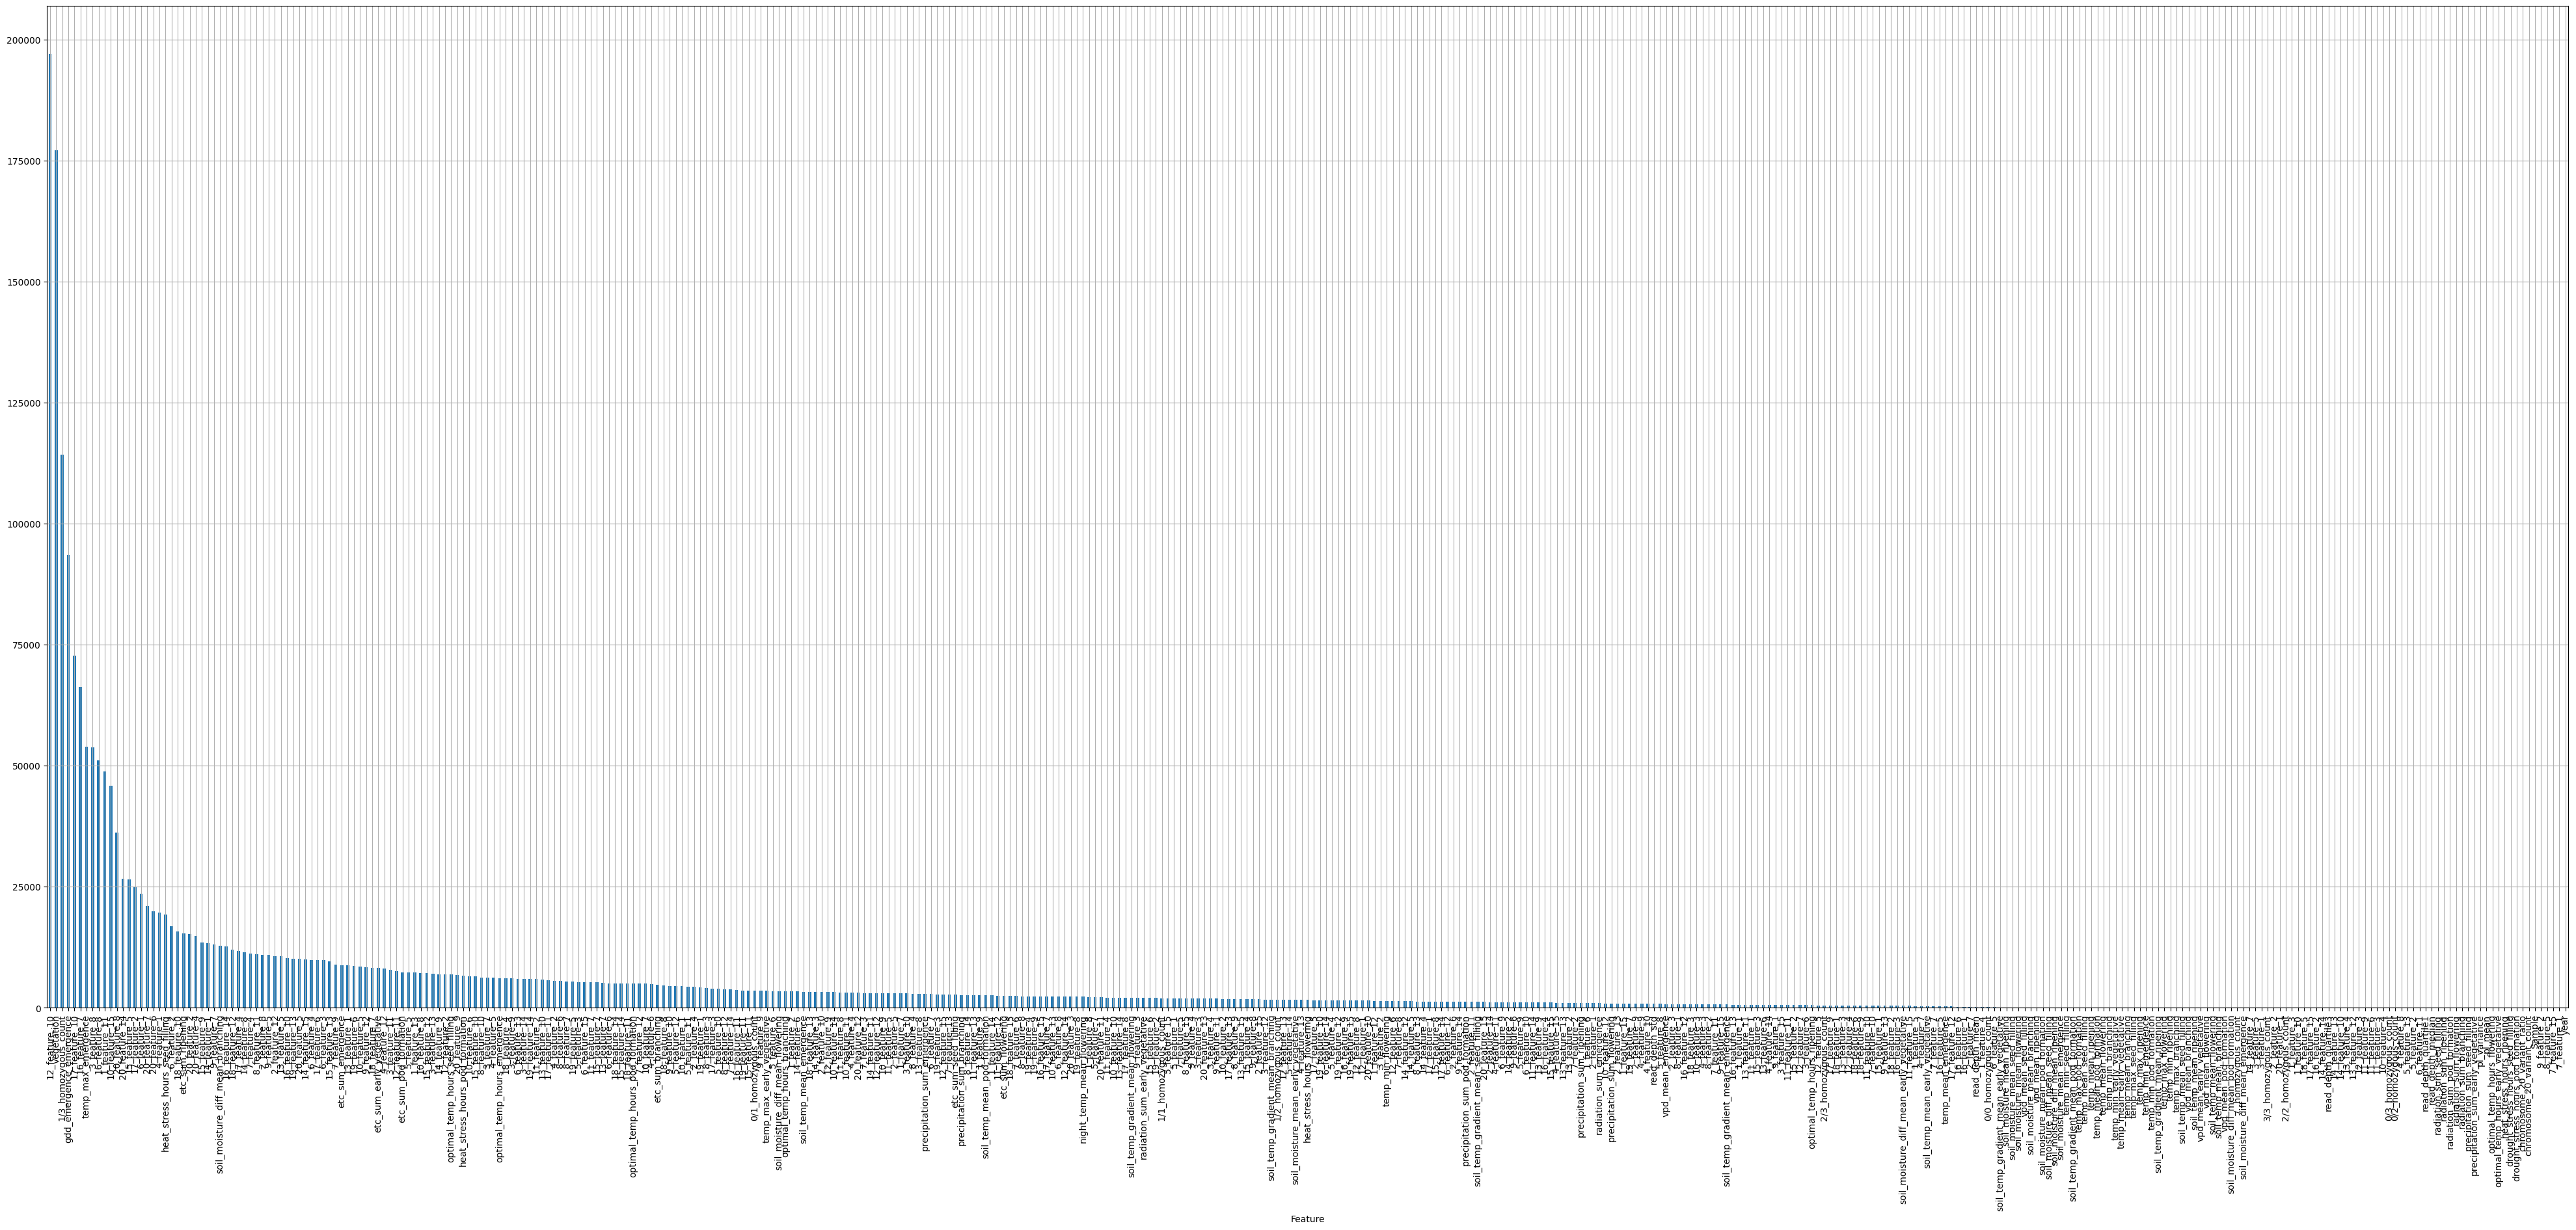

In [74]:
accurate_fi = automl_rd.model.get_feature_scores('fast')
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(50, 20), grid=True)